In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance



from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures
from shapely.geometry import Point

In [2]:
# function that performs feature engineering on a dataset
def feature_engineering(df):
    # calculate person per bedroom
    df['PersonPerBedroom'] = df['AveOccup'] / df['AveBedrms']
    
    # calculate the magnitude of longitude and latitude difference to major cities
    df['LatDiff_LA'] = df['Latitude'] - 34.052
    df['LongDiff_LA'] = df['Longitude'] + 118.244
    df['Distance_LA'] = np.sqrt(df['LatDiff_LA'] ** 2 + df['LongDiff_LA'] ** 2)
    df = df.drop(['LatDiff_LA', 'LongDiff_LA'], axis = 1)

    df['LatDiff_SJ'] = df['Latitude'] - 37.339
    df['LongDiff_SJ'] = df['Longitude'] + 121.895
    df['Distance_SJ'] = np.sqrt(df['LatDiff_SJ'] ** 2 + df['LongDiff_SJ'] ** 2)
    df = df.drop(['LatDiff_SJ', 'LongDiff_SJ'], axis = 1)

    df['LatDiff_SD'] = df['Latitude'] - 32.716
    df['LongDiff_SD'] = df['Longitude'] + 117.165
    df['Distance_SD'] = np.sqrt(df['LatDiff_SD'] ** 2 + df['LongDiff_SD'] ** 2)
    df = df.drop(['LatDiff_SD', 'LongDiff_SD'], axis = 1)

    df['LatDiff_SF'] = df['Latitude'] - 37.775
    df['LongDiff_SF'] = df['Longitude'] + 122.419
    df['Distance_SF'] = np.sqrt(df['LatDiff_SF'] ** 2 + df['LongDiff_SF'] ** 2)
    df = df.drop(['LatDiff_SF', 'LongDiff_SF'], axis = 1)
    
    # calculate the proximity to the ocean
    Long = []
    Lat = []

    for i in df.Longitude.unique():
        mini_df = df[df.Longitude == i]
        Long.append(i)
        Lat.append(mini_df['Latitude'].min())

    pairs = pd.DataFrame({'Longitude' : Long, 'Latitude': Lat})
    df['Min_Latitude'] = df.Longitude.apply(lambda x: pairs[pairs.Longitude == x].Latitude.values[0])
    df['Proximity_to_Ocean'] = df['Latitude'] - df['Min_Latitude']
    df = df.drop('Min_Latitude', axis = 1)
    
    return df

In [3]:
# function that calculates the metrics
def metrics(ytest, pred):
    print('MSE:', mean_squared_error(ytest, pred))
    print('R^2:', r2_score(ytest, pred))

In [4]:
# function that calculates the metrics on the holdout set
def evaluate(model, df, holdout_set):
    holdout_set = feature_engineering(holdout_set)
    model.fit(df.drop('Price', axis = 1), df.Price)
    predictions = model.predict(holdout_set.drop('Price', axis = 1))
    print('MSE:', mean_squared_error(holdout_set.Price, predictions))
    print('R^2:', r2_score(holdout_set.Price, predictions))

## Exploratory Data Analysis & Data Preprocessing

In [5]:
# read in the dataset and the holdout set
df = pd.read_csv('housing_data_test_train.csv').drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)
holdout = pd.read_csv('housing_data_holdout_set.csv').drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)

In [6]:
# look at the first 5 rows of the dataset
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697


In [7]:
# get summary statistics for all the variables
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.876149,28.604469,5.441114,1.099598,1425.257146,3.094971,35.632194,-119.574288,2.077351
std,1.891584,12.586046,2.613727,0.507173,1123.756792,11.597402,2.137087,2.007578,1.155945
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.300000,0.149990
25%,2.572050,18.000000,4.439906,1.006260,786.000000,2.427283,33.930000,-121.810000,1.206000
50%,3.544550,29.000000,5.226528,1.048797,1164.000000,2.813449,34.260000,-118.490000,1.806000
75%,4.750000,37.000000,6.057778,1.099574,1723.000000,3.273834,37.710000,-118.010000,2.660000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


<AxesSubplot:>

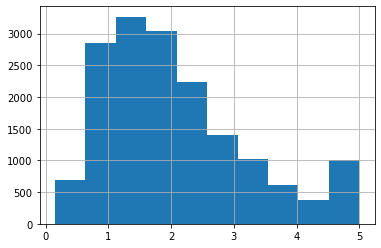

In [8]:
# plot histogram for price
df.Price.hist()

In [9]:
# calculate the correlation between all the variables and Price
df.corr()['Price'].sort_values(ascending = False)[1:]

MedInc        0.688194
AveRooms      0.146508
HouseAge      0.105758
AveOccup     -0.021979
Population   -0.023884
AveBedrms    -0.041592
Longitude    -0.050893
Latitude     -0.139374
Name: Price, dtype: float64

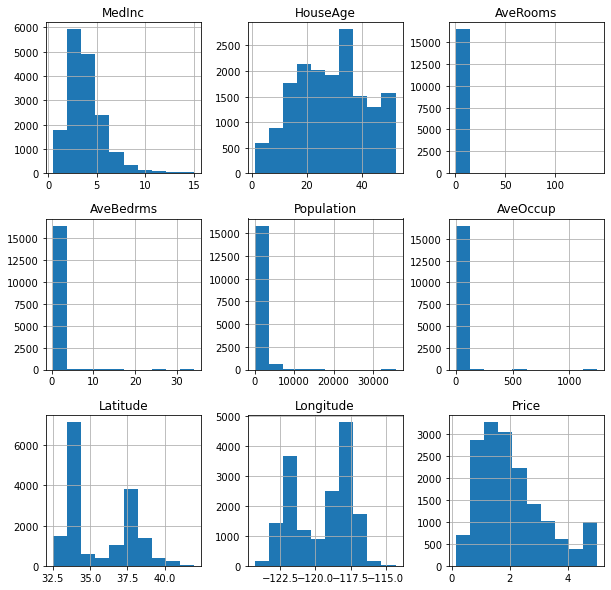

In [10]:
# plot histograms for all the variables
df.hist(figsize = (10, 10))
plt.show()

In [11]:
# see all the rows that have AveRooms > 50
df[df['AveRooms'] > 50]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
1525,4.9750,16.0,56.269231,10.153846,54.0,2.076923,39.01,-120.16,2.06300
1526,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06,4.37500
1527,1.8750,33.0,141.909091,25.636364,30.0,2.727273,38.91,-120.10,5.00001
1571,4.6250,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08,1.62500
7716,3.2431,14.0,52.848214,11.410714,265.0,2.366071,37.64,-119.02,2.21400
9349,1.1912,22.0,52.690476,8.857143,98.0,2.333333,39.15,-120.06,1.70000
9471,2.6250,25.0,59.875000,15.312500,28.0,1.750000,40.27,-121.25,0.67500
9920,1.6154,17.0,62.422222,14.111111,83.0,1.844444,33.97,-114.49,0.87500


In [12]:
# see all the rows that have AveOccup > 35
df[df['AveOccup'] > 35]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
2668,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51,0.67500
7073,9.3370,52.0,7.285714,1.214286,1154.0,41.214286,34.06,-118.45,5.00001
7322,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59,1.54600
9661,1.6250,8.0,7.600000,0.950000,1275.0,63.750000,33.97,-117.33,1.62500
10386,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15,2.25000
13315,4.2639,46.0,9.076923,1.307692,6532.0,502.461538,35.32,-120.70,3.50000
15206,10.2264,45.0,3.166667,0.833333,7460.0,1243.333333,38.32,-121.98,1.37500


In [13]:
# remove the rows that have AveRooms > 50
df = df[df['AveRooms'] < 50]

In [14]:
# remove the rows that have AveOccup > 35
df = df[df['AveOccup'] < 35]

In [15]:
# see all the rows that have AveBedrms > 10
df[df['AveBedrms'] > 10]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
988,3.125,11.0,47.515152,11.181818,82.0,2.484848,38.42,-120.19,0.775


In [16]:
# calculate the correlation between all the variables and Price
df.corr()['Price'].sort_values(ascending = False)[1:]

MedInc        0.688989
AveRooms      0.189667
HouseAge      0.105463
Population   -0.023665
Longitude    -0.050868
AveBedrms    -0.070057
Latitude     -0.139558
AveOccup     -0.227828
Name: Price, dtype: float64

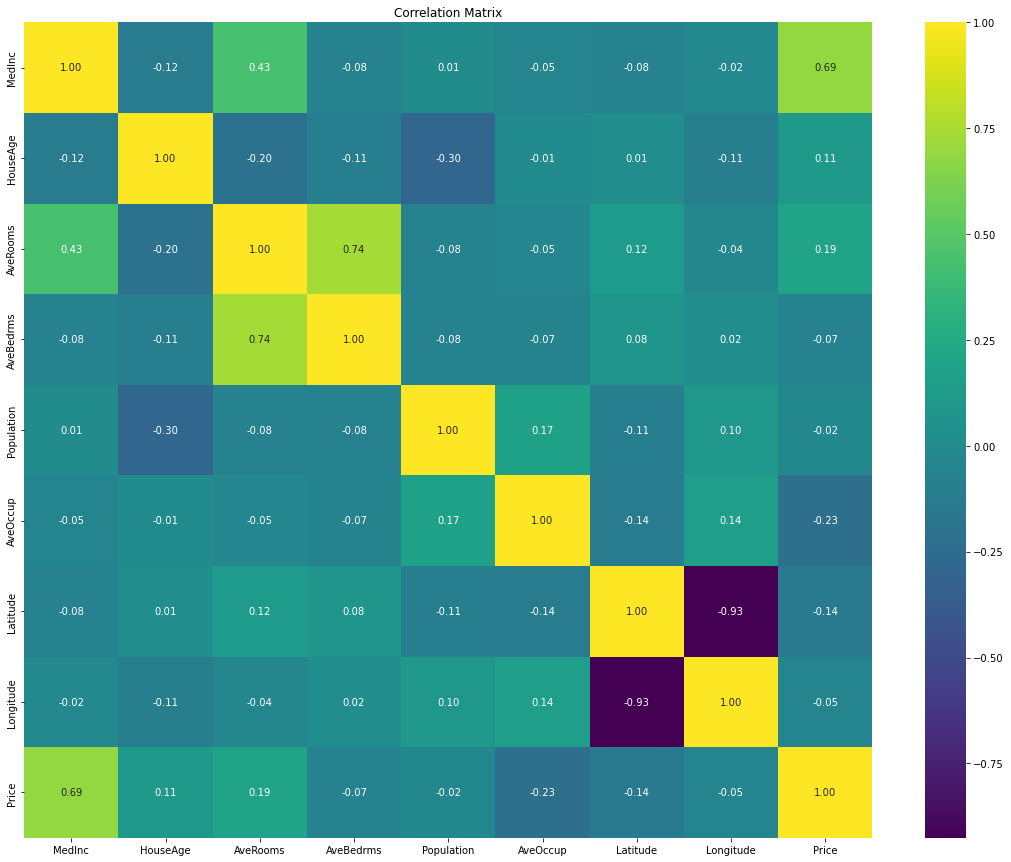

In [17]:
# plot a correlation matrix
f = plt.figure(figsize = (19, 15))
heatmap = sns.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'viridis')
plt.title('Correlation Matrix')
plt.show()

In [18]:
# perform feature engineering on the dataset
df = feature_engineering(df)

In [19]:
# get summary statistics for all the variables
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price,PersonPerBedroom,Distance_LA,Distance_SJ,Distance_SD,Distance_SF,Proximity_to_Ocean
count,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000,16497.000000
mean,3.875699,28.604777,5.405688,1.092205,1424.326423,2.929169,35.630526,-119.574269,2.077148,2.768106,2.649060,3.480581,3.858114,3.873441,0.635896
std,1.890787,12.583564,1.931062,0.333898,1119.794051,0.909446,2.136209,2.007766,1.155654,0.952575,2.416234,2.187354,2.829923,2.506410,0.794256
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.300000,0.149990,0.179389,0.004472,0.005099,0.006403,0.005099,0.000000
25%,2.572100,18.000000,4.439446,1.006250,787.000000,2.427389,33.930000,-121.810000,1.206000,2.256000,0.318653,1.064963,1.516529,1.198326,0.140000
50%,3.544400,29.000000,5.225726,1.048780,1164.000000,2.813518,34.250000,-118.490000,1.806000,2.683644,1.697963,4.594983,2.071536,5.270342,0.330000
75%,4.750000,37.000000,6.055422,1.099448,1723.000000,3.273490,37.710000,-118.010000,2.660000,3.161017,5.200079,5.164369,6.902588,5.845674,0.770000
max,15.000100,52.000000,47.515152,11.181818,35682.000000,33.952941,41.950000,-114.310000,5.000010,30.900000,9.865499,8.587634,11.582556,9.263841,7.200000


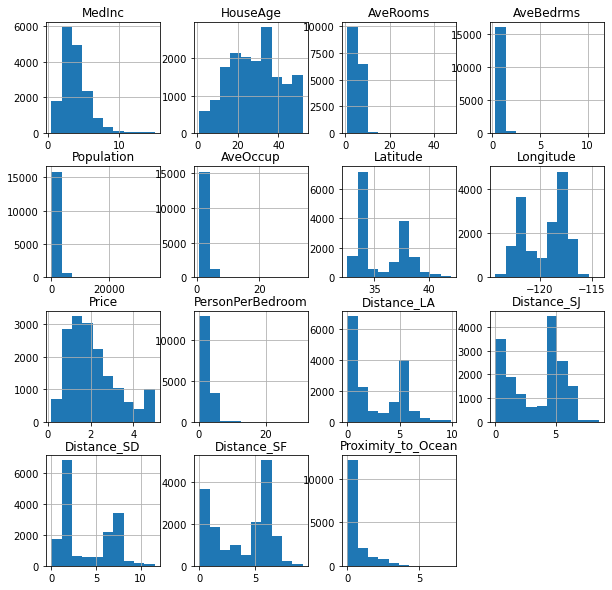

In [20]:
# plot histograms for all the variables
df.hist(figsize = (10, 10))
plt.show()

In [21]:
# calculate the correlation between all the variables and Price
df.corr()['Price']

MedInc                0.688989
HouseAge              0.105463
AveRooms              0.189667
AveBedrms            -0.070057
Population           -0.023665
AveOccup             -0.227828
Latitude             -0.139558
Longitude            -0.050868
Price                 1.000000
PersonPerBedroom     -0.179399
Distance_LA          -0.111693
Distance_SJ          -0.052725
Distance_SD          -0.073140
Distance_SF          -0.046246
Proximity_to_Ocean   -0.380570
Name: Price, dtype: float64

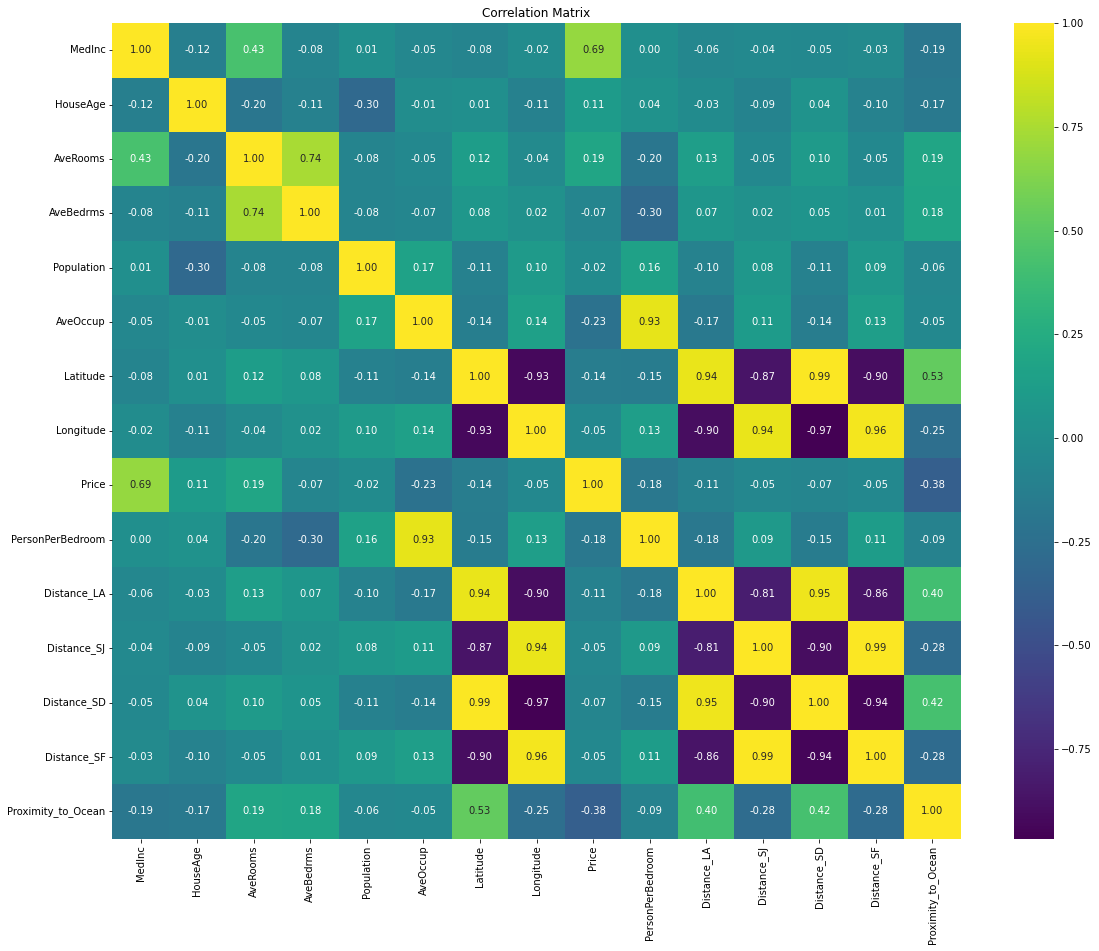

In [22]:
# plot a correlation matrix
f = plt.figure(figsize = (19, 15))
heatmap = sns.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = 'viridis')
plt.title('Correlation Matrix')
plt.show()

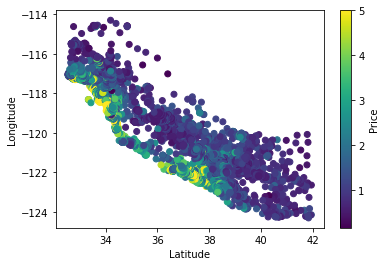

In [23]:
# plot latitude vs longitude coloured by price
plt.scatter(np.array(df.Latitude), np.array(df.Longitude), c = df.Price)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label = "Price")
plt.show()

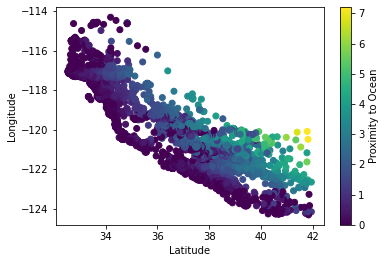

In [24]:
# plot latitude vs longitude coloured by proximity to ocean
plt.scatter(np.array(df.Latitude), np.array(df.Longitude), c = df.Proximity_to_Ocean)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label = "Proximity to Ocean")
plt.show()

In [25]:
# split the dataset into train and test sets 
X = df.drop('Price', axis = 1)
y = df.Price

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Linear Regression

In [26]:
# fit a linear regression model to the data
lin_reg = LinearRegression()
lin_reg = lin_reg.fit(Xtrain, ytrain)
lin_pred = lin_reg.predict(Xtest)

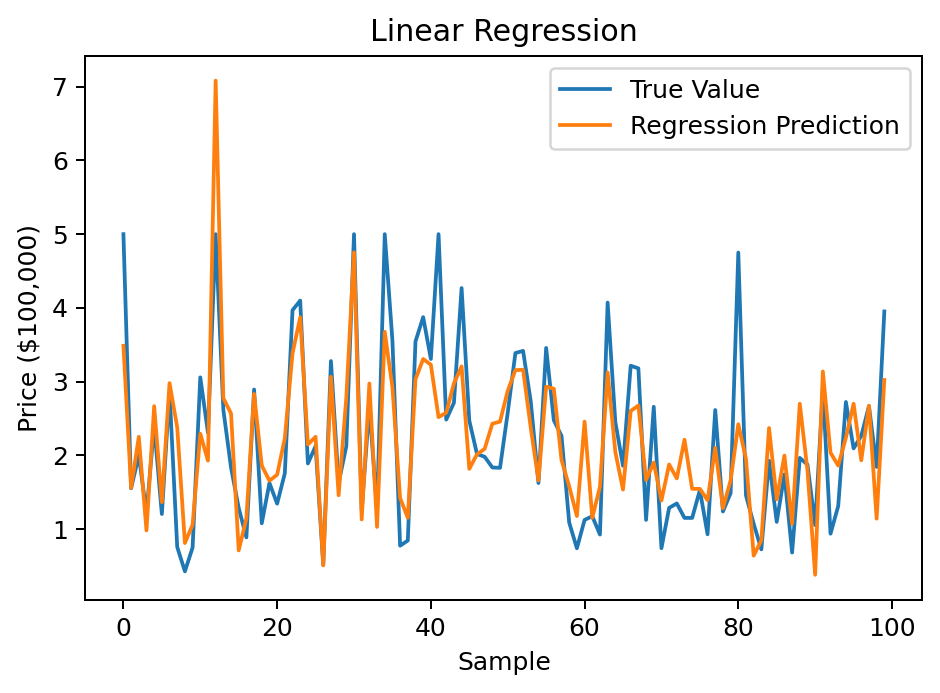

MSE: 0.44458993029510807
R^2: 0.6523511344638022


In [27]:
# plot the true values and predicted values of the first 100 observations
plt.figure(dpi = 180)
testing = np.array([i for i in range(len(ytest))])
plt.plot(testing[:100], np.array(ytest)[:100], label = 'True Value')
plt.plot(testing[:100], lin_pred[:100], label = 'Regression Prediction')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Price ($100,000)')
plt.title('Linear Regression')
plt.show()

# calculate the scores for the model
metrics(ytest, lin_pred)

## Ridge Regularization

In [28]:
# find the best parameters
ridgecv = RidgeCV(alphas = [1e-3, 1e-2, 1e-1, 1, 20, 50, 100], cv = 5)
ridgecv.fit(Xtrain, ytrain)
best_alpha = ridgecv.alpha_
print(best_alpha)

20.0


In [29]:
# fit a linear regression model with ridge regularization to the data
ridge = Ridge(alpha = best_alpha)
ridge.fit(Xtrain, ytrain)
ridge_pred = ridge.predict(Xtest)

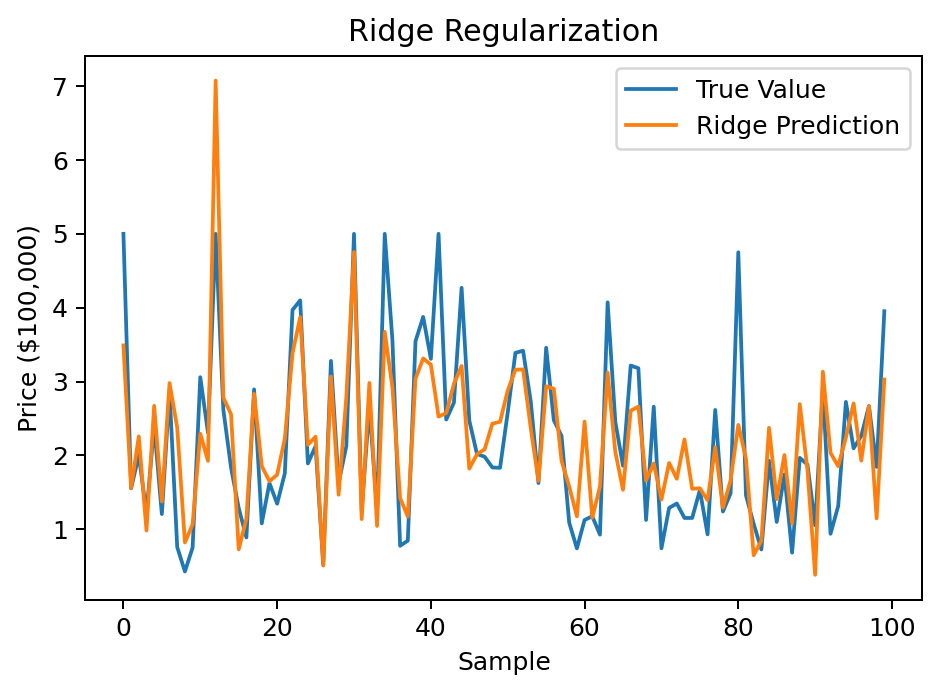

MSE: 0.4447557781462315
R^2: 0.6522214490765141


In [30]:
# plot the true values and predicted values of the first 100 observations
plt.figure(dpi = 180)
testing = np.array([i for i in range(len(ytest))])
plt.plot(testing[:100], np.array(ytest)[:100], label = 'True Value')
plt.plot(testing[:100], ridge_pred[:100], label = 'Ridge Prediction')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Price ($100,000)')
plt.title('Ridge Regularization')
plt.show()

# calculate the scores for the model
metrics(ytest, ridge_pred)

## Lasso Regularization

In [31]:
# find the best parameters and fit a linear regression model with lasso regularization to the data
lassocv = LassoCV(eps = 8e-3, n_alphas = 50, cv = 5, random_state = 0)
lassocv.fit(Xtrain, ytrain)
best_alpha = lassocv.alpha_
print(best_alpha)
lasso_pred = lassocv.predict(Xtest)

0.2631434229820969


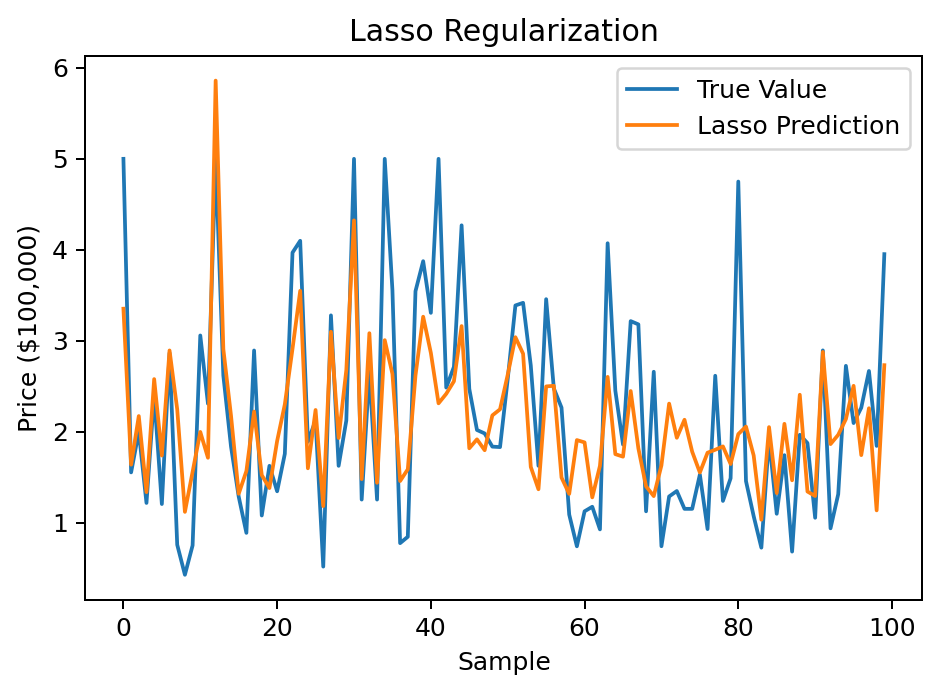

MSE: 0.6196916793584054
R^2: 0.5154296248496446


In [32]:
# plot the true values and predicted values of the first 100 observations
plt.figure(dpi = 180)
testing = np.array([i for i in range(len(ytest))])
plt.plot(testing[:100], np.array(ytest)[:100], label = 'True Value')
plt.plot(testing[:100], lasso_pred[:100], label = 'Lasso Prediction')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Price ($100,000)')
plt.title('Lasso Regularization')
plt.show()

# calculate the scores for the model
metrics(ytest, lasso_pred)

## Elastic Net Regularization

In [33]:
# find the best parameters
elasticnet_cv = ElasticNetCV(eps = 8e-3, 
                             n_alphas = 20, 
                             l1_ratio = [.1, .5, .7, .9, .95, .99, 1], 
                             alphas = None,
                             fit_intercept = True, 
                             max_iter = 1000,
                             tol = 0.001, 
                             cv = 3,
                             random_state = 0)
elasticnet_cv.fit(Xtrain, ytrain)
best_alpha_elasticnet = elasticnet_cv.alpha_
best_l1_ratio = elasticnet_cv.l1_ratio_
print(best_l1_ratio)
print(best_alpha_elasticnet)

1.0
0.2631434229820969


In [34]:
# fit a linear regression model with elastic net regularization to the data
elastic = ElasticNet(l1_ratio = best_l1_ratio, alpha = best_alpha_elasticnet, random_state = 0)
elastic.fit(Xtrain, ytrain)
elastic_pred = elastic.predict(Xtest)

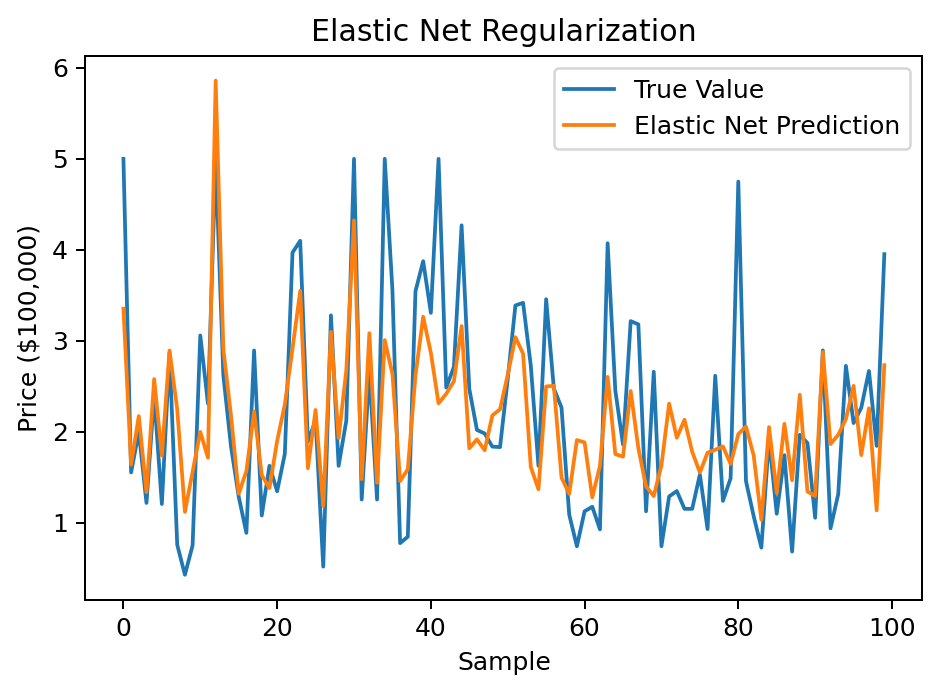

MSE: 0.6196916793584054
R^2: 0.5154296248496446


In [35]:
# plot the true values and predicted values of the first 100 observations
plt.figure(dpi = 180)
testing = np.array([i for i in range(len(ytest))])
plt.plot(testing[:100], np.array(ytest)[:100], label = 'True Value')
plt.plot(testing[:100], elastic_pred[:100], label = 'Elastic Net Prediction')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Price ($100,000)')
plt.title('Elastic Net Regularization')
plt.show()

# calculate the scores for the model
metrics(ytest, elastic_pred)

## Decision Tree

In [36]:
# fit a decision tree to the data
decision_tree = DecisionTreeRegressor(max_depth = 7)
decision_tree.fit(Xtrain, ytrain)
decision_tree_pred = decision_tree.predict(Xtest)

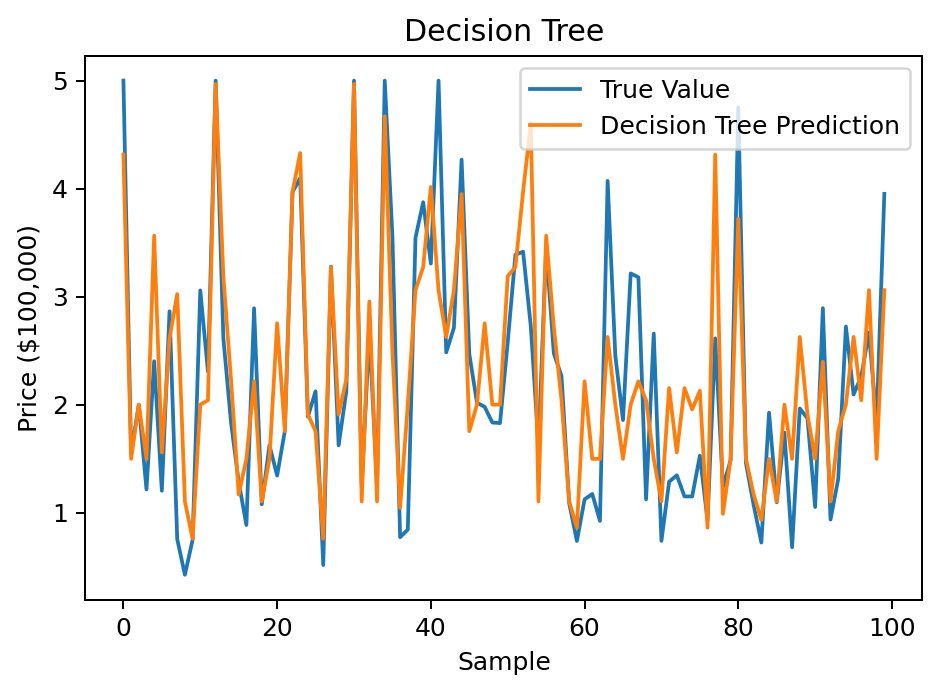

MSE: 0.4051285236596674
R^2: 0.683208138445353


In [37]:
# plot the true values and predicted values of the first 100 observations
plt.figure(dpi = 180)
testing = np.array([i for i in range(len(ytest))])
plt.plot(testing[:100], np.array(ytest)[:100], label = 'True Value')
plt.plot(testing[:100], decision_tree_pred[:100], label = 'Decision Tree Prediction')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Price ($100,000)')
plt.title('Decision Tree')
plt.show()

# calculate the scores for the model
metrics(ytest, decision_tree_pred)

## Random Forest

In [38]:
# fit a random forest to the data
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf.fit(Xtrain, ytrain)
rf_pred = rf.predict(Xtest)

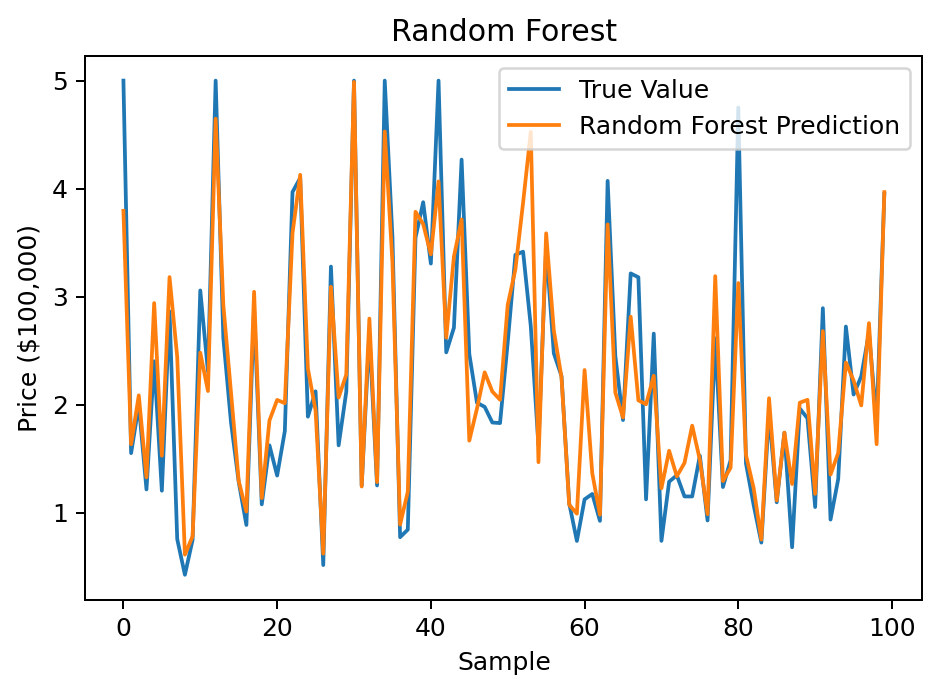

MSE: 0.23617241475235914
R^2: 0.815324040278864


In [39]:
# plot the true values and predicted values of the first 100 observations
plt.figure(dpi = 180)
testing = np.array([i for i in range(len(ytest))])
plt.plot(testing[:100], np.array(ytest)[:100], label = 'True Value')
plt.plot(testing[:100], rf_pred[:100], label = 'Random Forest Prediction')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Price ($100,000)')
plt.title('Random Forest')
plt.show()

# calculate the scores for the model
metrics(ytest, rf_pred)

## Extreme Gradient Boosted Tree

In [40]:
# fit an extreme gradient boosted tree to the data
xgb_tree = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 7, objective = 'reg:squarederror')
xgb_tree.fit(Xtrain, ytrain)
xgb_tree_pred = xgb_tree.predict(Xtest)

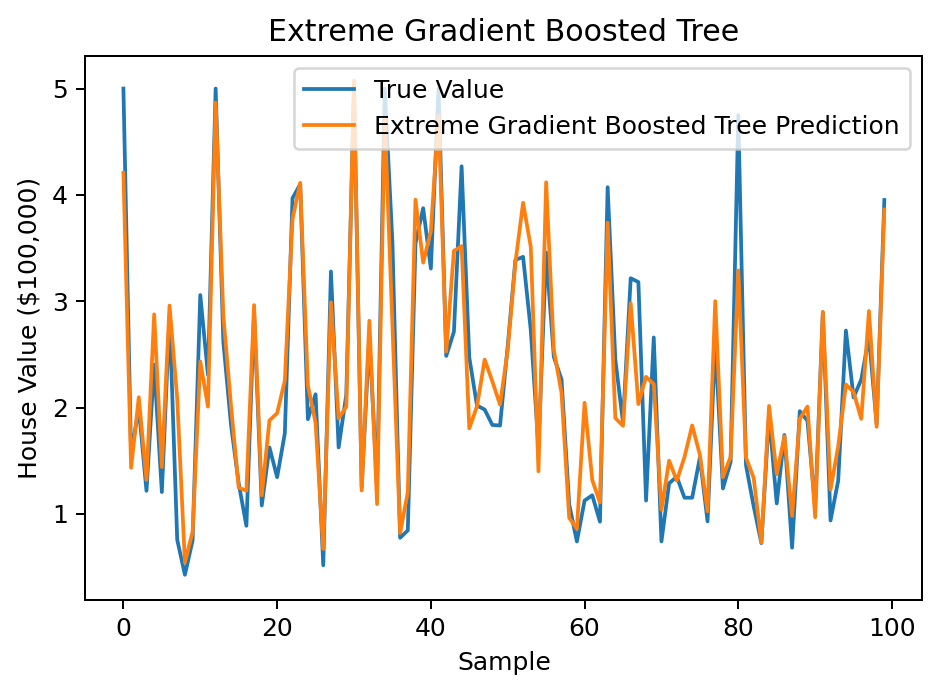

MSE: 0.2032487415348508
R^2: 0.8410688375929951


In [41]:
# plot the true values and predicted values of the first 100 observations
plt.figure(dpi = 180)
testing = np.array([i for i in range(len(ytest))])
plt.plot(testing[:100], np.array(ytest)[:100], label = 'True Value')
plt.plot(testing[:100], xgb_tree_pred[:100], label = 'Extreme Gradient Boosted Tree Prediction')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('House Value ($100,000)')
plt.title('Extreme Gradient Boosted Tree')
plt.show()

# calculate the scores for the model
metrics(ytest, xgb_tree_pred)

## Hyperparameter Fine-Tuning on Best Model - Extreme Gradient Boosted Tree

In [42]:
# find best parameters
xgb_tree = xgb.XGBRegressor(objective = 'reg:squarederror')

# set up the search grid
param_grid = {'max_depth': [4, 5, 6, 7],
              'n_estimators': [500, 600, 700],
              'learning_rate': [0.01, 0.015, 0.1]}

# try out every combination of the above values
search = GridSearchCV(xgb_tree, param_grid, cv = 5).fit(Xtrain, ytrain)

print('The best hyperparameters are ', search.best_params_)

The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 700}


In [43]:
# fit a boosted tree to the data
xgb_tree_best = xgb.XGBRegressor(learning_rate = search.best_params_['learning_rate'],
                                n_estimators = search.best_params_['n_estimators'],
                                max_depth = search.best_params_['max_depth'],
                                objective = 'reg:squarederror')

xgb_tree_best.fit(Xtrain, ytrain)
xgb_tree_best_pred = xgb_tree_best.predict(Xtest)

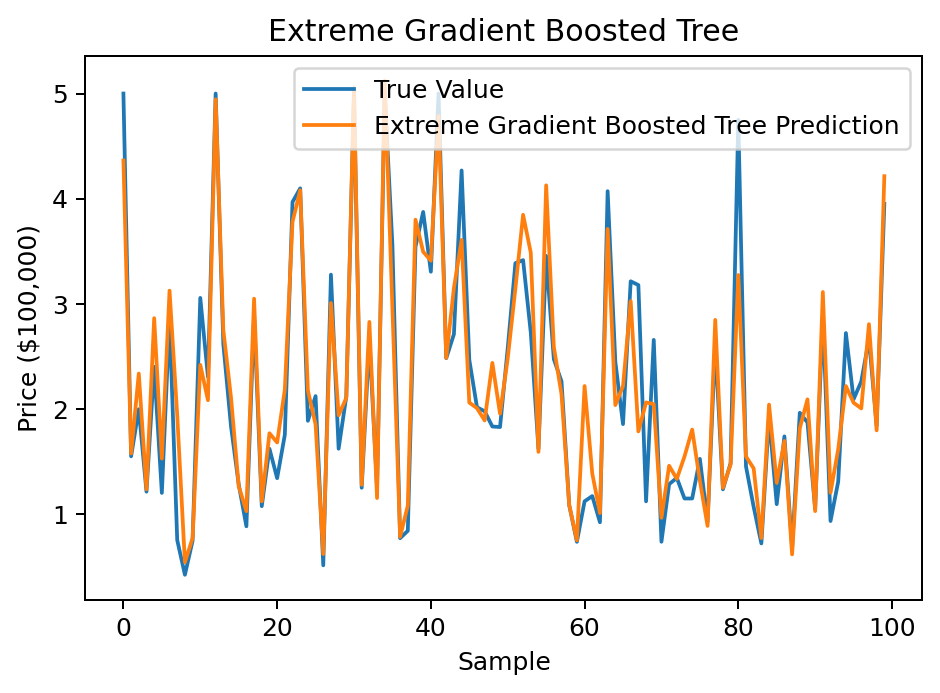

MSE: 0.1878067166129354
R^2: 0.8531437904425169


In [44]:
# plot the true values and predicted values of the first 100 observations
plt.figure(dpi = 180)
testing = np.array([i for i in range(len(ytest))])
plt.plot(testing[:100], np.array(ytest)[:100], label = 'True Value')
plt.plot(testing[:100], xgb_tree_best_pred[:100], label = 'Extreme Gradient Boosted Tree Prediction')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Price ($100,000)')
plt.title('Extreme Gradient Boosted Tree')
plt.show()

# calculate the scores for the model
metrics(ytest, xgb_tree_best_pred)

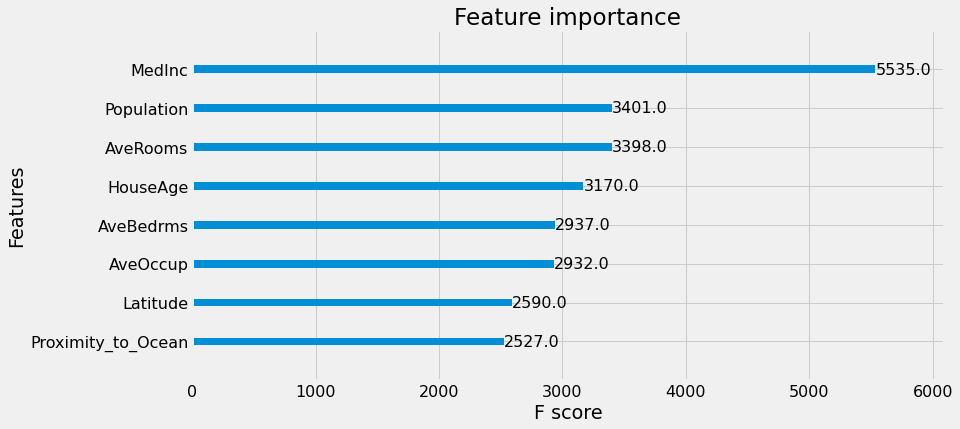

In [45]:
# plot variable importance
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize = (12,6))
plot_importance(xgb_tree_best, max_num_features = 8, ax = ax)
plt.show()

In [46]:
# evaluate on holdout set
evaluate(xgb_tree_best, df, holdout)

MSE: 0.19939428311769822
R^2: 0.8479868300549696


In [47]:
# save best model to .pkl file
# import pickle
# with open('xgboost_non-ai.pkl', 'wb') as file:
#     pickle.dump(xgb_tree_best, file)

In [49]:
# opening .pkl file
with open('xgboost_non-ai.pkl', 'rb') as file:
    model = pickle.load(file)

In [50]:
# function to evaluate the model from .pkl file
def evaluate_existing(model, holdout_set):
    holdout_set = feature_engineering(holdout_set)
    predictions = model.predict(holdout_set.drop('Price', axis = 1))
    print('MSE:', mean_squared_error(holdout_set.Price, predictions))
    print('R^2:', r2_score(holdout_set.Price, predictions))

In [52]:
# metrics on holdout set using .pkl file model
evaluate_existing(model, holdout)

MSE: 0.19939428311769822
R^2: 0.8479868300549696
